In [1]:
#Importing relevant libraries
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
#Connecting to the database
conn_str = ('DRIVER={ODBC Driver 17 for SQL Server};Server=analiza.database.windows.net;Database=AnalizaDB;UID=qa3107;PWD=fA8r2J2_DZH<;')
conn = pyodbc.connect(conn_str)

In [3]:
#Data Collection And Loading
datasets_names= ['Products','Suppliers','[Order Details]','Categories','Territories','Region','EmployeeTerritories','Employees','Orders','Shippers','Customers']
dataframes = [] #a list of all dataframes loaded, later used for quick review of all datasets loaded. 
def get_dataset(dataset):
    dataset = pd.read_sql(f"SELECT * FROM Northwind.{dataset}", conn)
    return dataset

for dataset in datasets_names:
    dataframe = get_dataset(dataset)
    dataframe.name = f'{dataset}' #Adding a name for each dataframe for later readability
    dataframes.append(dataframe) 

conn.close

C:\Users\ys170\AppData\Local\Temp\ipykernel_11824\3349389208.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dataset = pd.read_sql(f"SELECT * FROM Northwind.{dataset}", conn)


<function Connection.close()>

In [4]:
#Making sure all data was loaded properly

#looking for 11 dataframes 
print(len(dataframes)) 
for df in dataframes:
    print(type(df))

#Making sure each dataset was loaded at full size with all fields and columns. 
for df in dataframes:
    print(df.name)
    print(df.shape)
    print(df.info())
    print("--------\n")

11
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
Products
(77, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ProductID        77 non-null     int64  
 1   ProductName      77 non-null     object 
 2   SupplierID       77 non-null     int64  
 3   CategoryID       77 non-null     int64  
 4   QuantityPerUnit  77 non-null     object 
 5   UnitPrice        77 non-null     float64
 6   UnitsInStock     77 non-null     int64  
 7   UnitsOnOrder     77 non-null     int64 

In [5]:
#Isolating each dataset 

Products = dataframes[0]
Suppliers = dataframes[1]
OrderDetails = dataframes[2]
Categories = dataframes[3]
Territories = dataframes[4]
Region = dataframes[5]
EmployeeTerritories = dataframes[6]
Employees = dataframes[7]
Orders = dataframes[8]
Shippers = dataframes[9]
Customers = dataframes[10]


In [6]:
#Data Cleaning and Preprocessing 

#Renaming [Order Details] both on the isolated dataframe and on the dataframes list
OrderDetails.name = 'OrderDetails'
dataframes[2].name = 'OrderDetails'

#Renaming UnitPrice column in Products to improve clarity.
Products.rename(columns= {'UnitPrice':'UnitCost'},inplace=True)
#Renaming Shipvia column in Orders to improve clarity
Orders.rename(columns= {'ShipVia':'ShipperID'},inplace=True)



Empty DataFrame
Columns: [ProductID, OrderCount, ProductName]
Index: []
Empty DataFrame
Columns: [ProductID, OrderCount, ProductName]
Index: []
   ProductID  OrderCount             ProductName
0         59          54    Raclette Courdavault
1         31          51       Gorgonzola Telino
2         60          51       Camembert Pierrot
3         24          51      Guaranב Fantבstica
4         56          50  Gnocchi di nonna Alice
    ProductID  OrderCount                ProductName
76          9           5            Mishi Kobe Niku
74         15           6               Genen Shouyu
73         37           6                 Gravad lax
75         48           6                  Chocolade
72         66           8  Louisiana Hot Spiced Okra


C:\Users\ys170\AppData\Local\Temp\ipykernel_11824\2761290548.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(bottom_bin['ProductName'], rotation=45, ha='right')


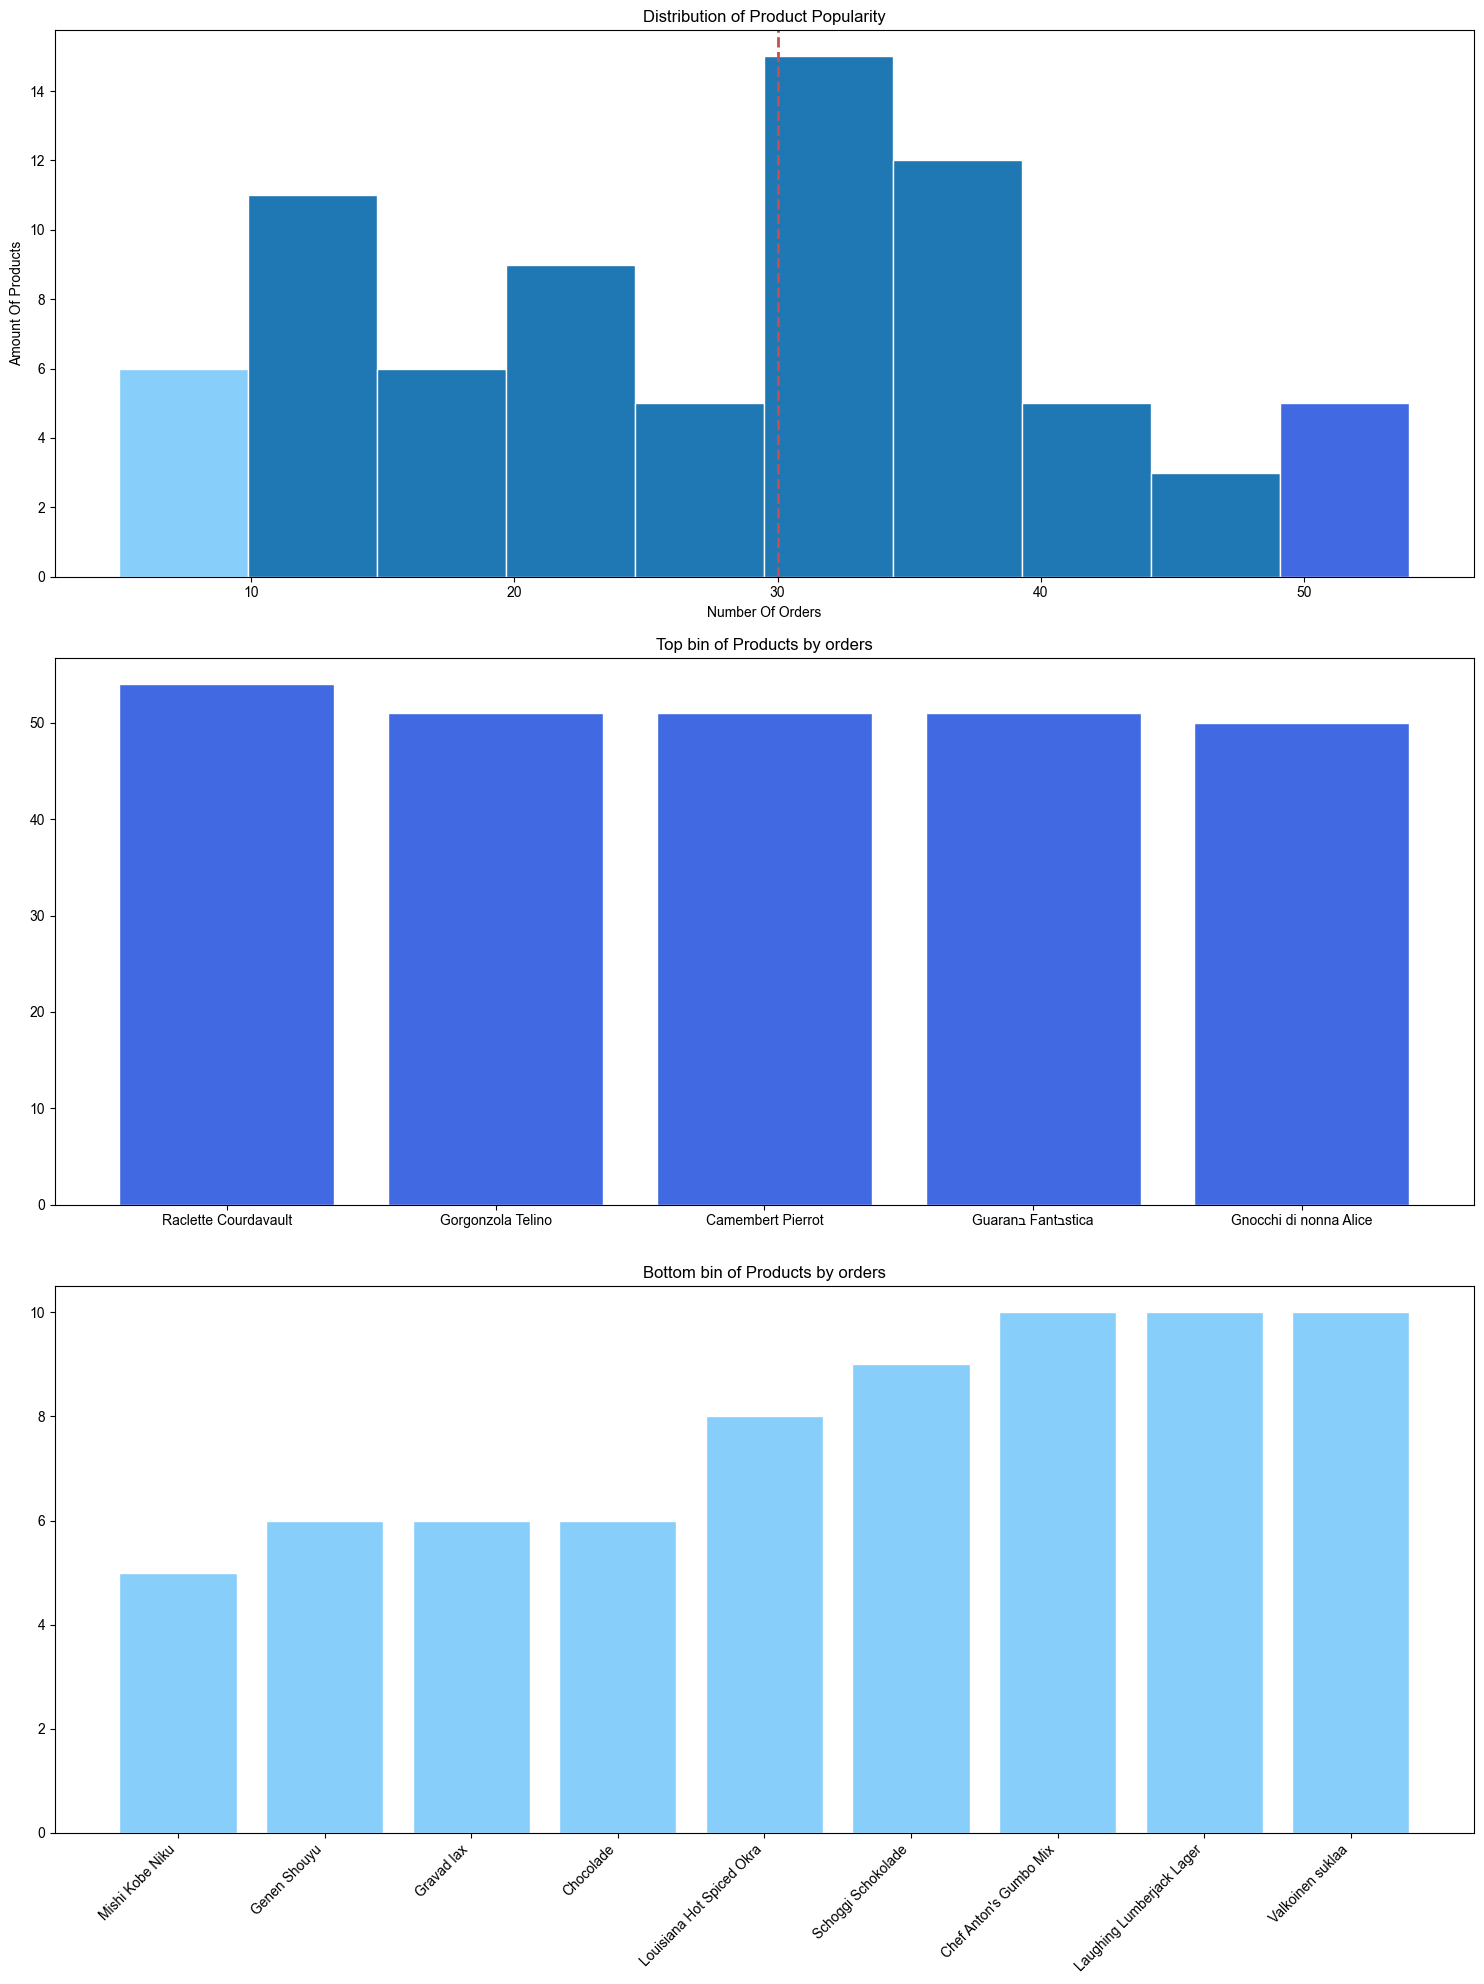

In [7]:
#What are the most popular products? Product statistics

orders_per_product = OrderDetails.groupby('ProductID')['OrderID'].count()
orders_per_product.sort_values(ascending=False,inplace=True)

df_full = pd.merge(orders_per_product,Products[['ProductID','ProductName']],on='ProductID')
df_full.rename(columns={'OrderID':'OrderCount'},inplace= True)

#A function for getting outliers statistcs 
def get_outliers(data,colname):
    data_range = data[colname]
    median = np.percentile(data_range,50)
    Q3 = np.percentile(data_range,75)
    Q1 = np.percentile(data_range,25)
    IQR = Q3- Q1
    high_outlier = Q3 + (1.5*IQR)
    low_outlier = Q1 - (1.5*IQR)
    mean=data_range.mean()
    results= {
        'median':median,
        'Q3':Q3,
        'Q1':Q1,
        'IQR':IQR,
        'high_outlier':high_outlier,
        'low_outlier':low_outlier,
        'mean':mean,
        'df_high_outliers':data[data[colname]>high_outlier],
        'df_low_outliers':data[data[colname]<low_outlier]
    }
    return results

#Calculating Outliers
outliers= get_outliers(df_full,'OrderCount')
print(outliers['df_high_outliers'])
print(outliers['df_low_outliers'])

#Creating a bar graph for each of the marginal bins
top_bin = df_full[df_full['OrderCount']>=50]
bottom_bin = df_full[df_full['OrderCount']<=10]
bottom_bin=bottom_bin.sort_values('OrderCount',ascending=True)
print(top_bin.head())#Top bin of distribution
print(bottom_bin.head())#Bottom bin of distribution

fig,axs =plt.subplots(3,1,figsize=(15,20))
sns.set_theme()

#Creating the set of graphs
axs[0].hist(df_full['OrderCount'],bins=10)
axs[0].set_title("Distribution of Product Popularity")
axs[0].set_xlabel('Number Of Orders')
axs[0].set_ylabel('Amount Of Products')
axs[0].patches[0].set_facecolor('lightskyblue')
axs[0].patches[-1].set_facecolor('royalblue')
axs[0].axvline(x=outliers['median'], color='r', linestyle='--', linewidth=2, label='Median')
axs[2].bar(bottom_bin['ProductName'],bottom_bin['OrderCount'],color = 'lightskyblue')
axs[2].set_xticklabels(bottom_bin['ProductName'], rotation=45, ha='right')
axs[2].set_title("Bottom bin of Products by orders")
axs[1].bar(top_bin['ProductName'],top_bin['OrderCount'],color = 'royalblue')
axs[1].set_title("Top bin of Products by orders")

plt.tight_layout()

Empty DataFrame
Columns: [UniqueCustomers, RepeatCustomerCount, RPR]
Index: []
Empty DataFrame
Columns: [UniqueCustomers, RepeatCustomerCount, RPR]
Index: []
   ProductID                 ProductName  UnitsInStock  Discontinued  \
0          8  Northwoods Cranberry Sauce             6         False   
1          9             Mishi Kobe Niku            29          True   
2         15                Genen Shouyu            39         False   
3         22         Gustaf's Knהckebrצd           104         False   
4         27          Schoggi Schokolade            49         False   
5         37                  Gravad lax            11         False   
6         48                   Chocolade            15         False   
7         66   Louisiana Hot Spiced Okra             4         False   
8         67   Laughing Lumberjack Lager            52         False   

   OrderCount  
0          13  
1           5  
2           6  
3          14  
4           9  
5           6  
6        

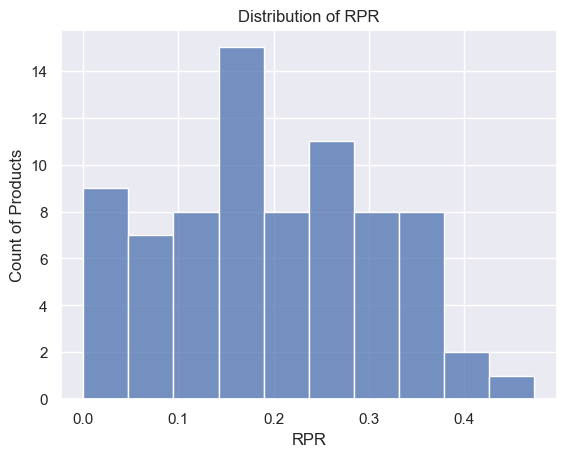

In [8]:
#Calculating RPR (Repeat Purchase Rate)

product_customers = OrderDetails.loc[:,['OrderID','ProductID']]
product_customers = pd.merge(product_customers,Orders[['OrderID','CustomerID']],on='OrderID')

#calculating unique customers per product
product_unique_customers=product_customers.groupby('ProductID').agg(UniqueCustomers=('CustomerID','nunique'))

#calculating repeating customers per product
product_repeat_customers = product_customers.groupby('ProductID')['CustomerID'].agg(RepeatCustomerCount=lambda x: (x.value_counts()>1).sum())

#Calculating RPR
df_rpr = pd.merge(product_unique_customers,product_repeat_customers,on='ProductID')
df_rpr['RPR']=df_rpr.apply(lambda row: row['RepeatCustomerCount']/row['UniqueCustomers'],axis=1)
df_rpr.sort_values(by='RPR',ascending=False,inplace=True)
rpr_outliers = get_outliers(df_rpr,'RPR')
print(rpr_outliers['df_high_outliers'])
print(rpr_outliers['df_low_outliers']) #no outliers

#Creating a list of all products with 0 RPR.
no_repeating_products = df_rpr.loc[(df_rpr['RPR']==0),['RPR']]
filtered_products = Products.loc[Products['ProductID'].isin(no_repeating_products.index),['ProductID','ProductName','UnitsInStock','Discontinued']]
filtered_products = pd.merge(filtered_products,df_full[['ProductID','OrderCount']])
print(filtered_products)

#Presenting the distribution of RPRs

sns.set_theme()
sns.histplot(df_rpr['RPR'],bins=10)
plt.ylabel('Count of Products')
plt.title('Distribution of RPR')
plt.savefig('RPR_distribution.png')

     OrderID CustomerID  EmployeeID  OrderDate RequiredDate ShippedDate  \
16     10264      FOLKO           6 1996-07-24   1996-08-21  1996-08-23   
17     10265      BLONP           2 1996-07-25   1996-08-22  1996-08-12   
23     10271      SPLIR           6 1996-08-01   1996-08-29  1996-08-30   
32     10280      BERGS           2 1996-08-14   1996-09-11  1996-09-12   
54     10302      SUPRD           4 1996-09-10   1996-10-08  1996-10-09   
..       ...        ...         ...        ...          ...         ...   
722    10970      BOLID           9 1998-03-24   1998-04-07  1998-04-24   
730    10978      MAISD           9 1998-03-26   1998-04-23  1998-04-23   
732    10980      FOLKO           4 1998-03-27   1998-05-08  1998-04-17   
738    10986      OCEAN           8 1998-03-30   1998-04-27  1998-04-21   
774    11022      HANAR           9 1998-04-14   1998-05-12  1998-05-04   

     ShipperID  Freight                   ShipName  \
16           3     3.67             Folk och 

C:\Users\ys170\AppData\Local\Temp\ipykernel_11824\2304619300.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Orders_cleaned['ShippingTime']= Orders_cleaned['ShippedDate']-Orders_cleaned['OrderDate']


Text(0.5, 1.0, 'Distribution of Shipping Time in Days')

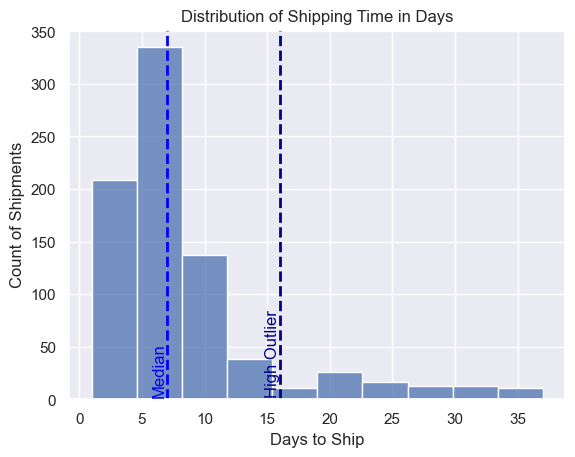

In [9]:
#Delivery time distribution
#checking for nulls
Orders[Orders['ShippedDate'].isnull()]
Orders.sort_values(by='ShippedDate',ascending=False)
#by comparing latest reported dates to the order date of orders which don't have a shipped date I conclude that orders that lack shipped date are orders not yet shipped. Therefore, I will remove them to continue analysis.
Orders_cleaned = Orders.dropna(subset='ShippedDate')

Orders_cleaned['ShippingTime']= Orders_cleaned['ShippedDate']-Orders_cleaned['OrderDate']

#Shipping Time Statistics
shippingtime_outliers = get_outliers(Orders_cleaned,'ShippingTime')
print(shippingtime_outliers['df_high_outliers']) #All shipments outliers in shipping time
num_of_shipments_outliers =shippingtime_outliers['df_high_outliers']['OrderID'].count()
num_of_total_shipmets = Orders_cleaned['OrderID'].count()
print(f'Number of shippments outliers: {num_of_shipments_outliers} \n which is {(num_of_shipments_outliers/num_of_total_shipmets)*100}% of total shipments')


#Histogram of distribution of shipping time
sns.set_theme()
sns.histplot(Orders_cleaned['ShippingTime'].dt.days,bins=10)
high_outlier_days = shippingtime_outliers['high_outlier'].astype('timedelta64[D]').astype(int)
median_days = shippingtime_outliers['median'].astype('timedelta64[D]').astype(int)
plt.axvline(x=high_outlier_days, color='darkblue', linestyle='--', linewidth=2,label='High Outlier')
plt.text(high_outlier_days, 1.5, 'High Outlier', color='darkblue', rotation=90, 
         va='bottom', ha='right')
plt.axvline(x=median_days, color='blue', linestyle='--', linewidth=2,label='Median')
plt.text(median_days, 1.5, 'Median', color='blue', rotation=90, 
         va='bottom', ha='right')
plt.ylabel('Count of Shipments')
plt.xlabel('Days to Ship')
plt.title("Distribution of Shipping Time in Days")


                     sum_sq    df         F    PR(>F)
C(ShipperID)      25.336992   2.0  0.383031  0.683192
C(ShipCountry)   588.674324  15.0  1.186567  0.302273
Residual        2348.280024  71.0       NaN       NaN


C:\Users\ys170\AppData\Local\Temp\ipykernel_11824\881351940.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shiptime_hiout['ShipTimeInDays']= df_shiptime_hiout['ShippingTime']/pd.Timedelta(days=1)


Text(0.5, 1.0, 'Median Shipping Time Between Destinations and Shippers')

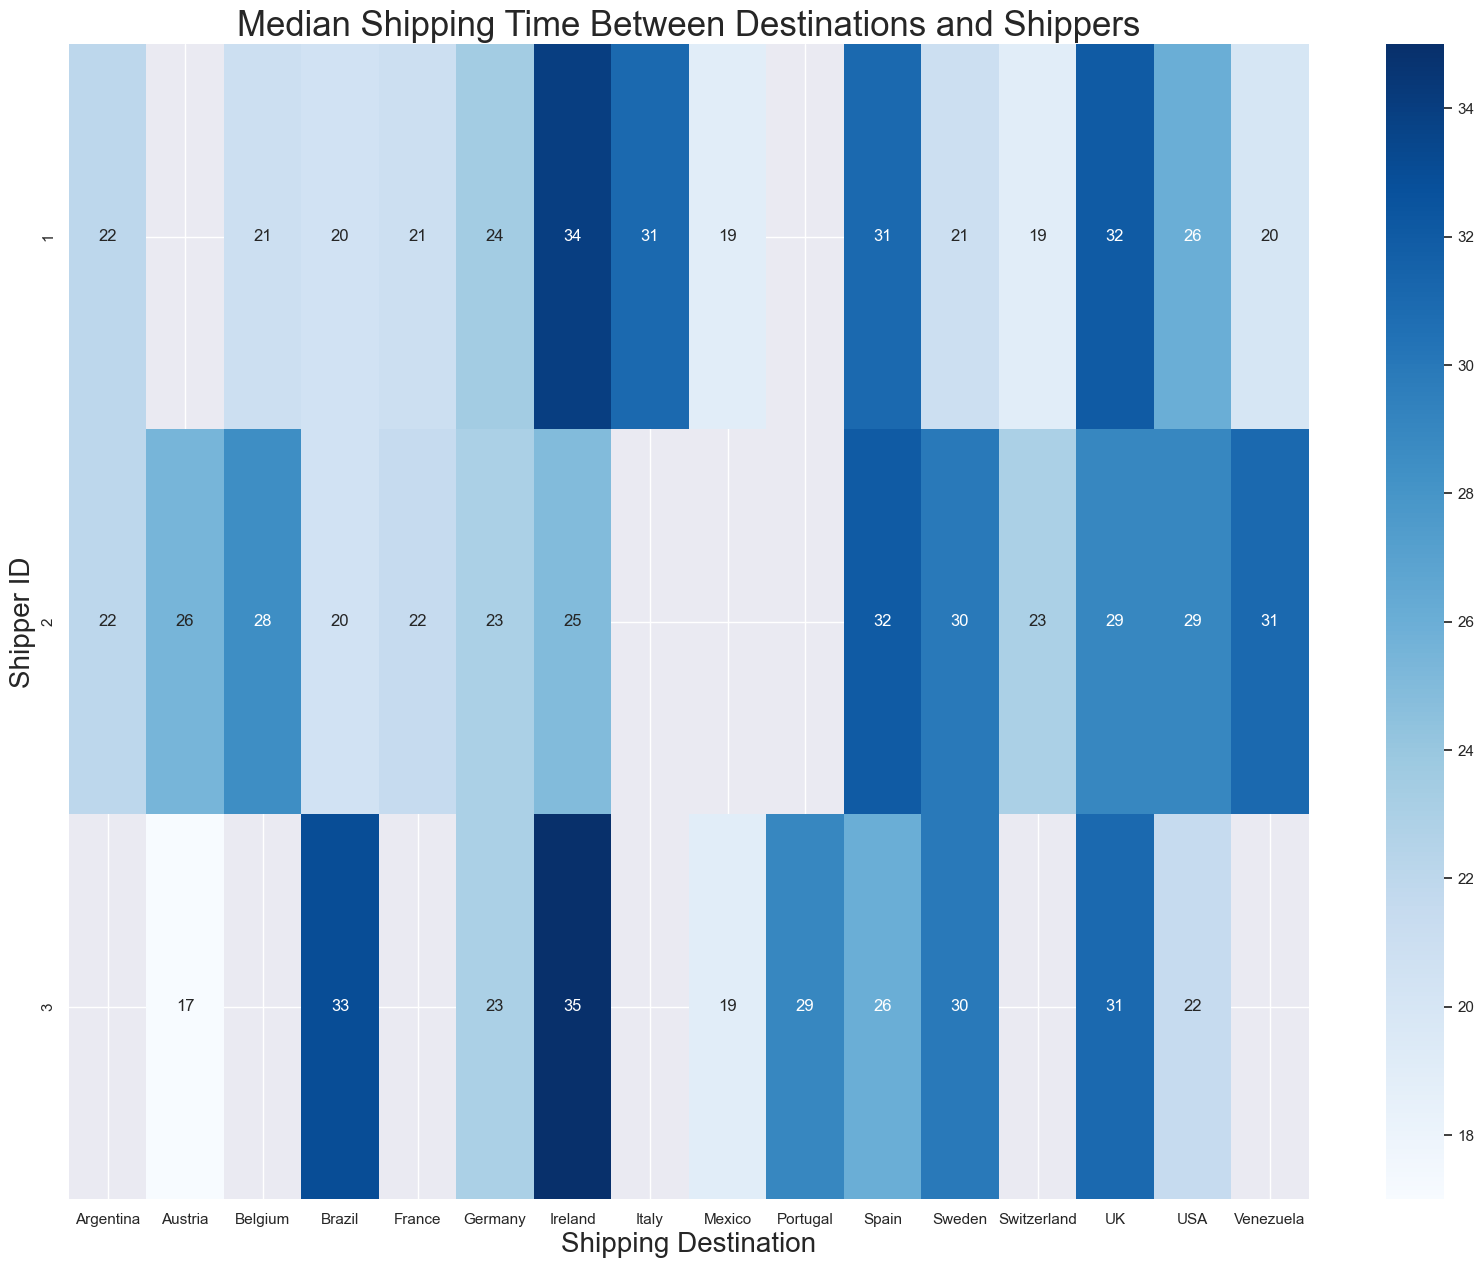

In [10]:
#Analysis of shipping time outliers
import statsmodels.api as sm
from statsmodels.formula.api import ols

#Data preprocessing
df_shiptime_hiout = shippingtime_outliers['df_high_outliers']
df_shiptime_hiout['ShipTimeInDays']= df_shiptime_hiout['ShippingTime']/pd.Timedelta(days=1)

#Using Ols to commit an ANOVA of the correlation between Shipping Time, Shipper ID and Country

model = ols('ShipTimeInDays ~ C(ShipperID) + C(ShipCountry)', data=df_shiptime_hiout).fit()
anova_results = sm.stats.anova_lm(model, typ=2)
print(anova_results)
#The results show there is not correlation, further analysis is required

#Creating A heatmap to visualize that there is no correlation
heatmap_data = df_shiptime_hiout.pivot_table(index='ShipperID', 
                             columns='ShipCountry', 
                             values='ShipTimeInDays', 
                             aggfunc='median')

plt.figure(figsize=(20,15))
sns.heatmap(heatmap_data,annot=True,cmap='Blues')
plt.xlabel('Shipping Destination',size=20)
plt.ylabel('Shipper ID',size =20)
plt.title('Median Shipping Time Between Destinations and Shippers',size=25)


C:\Users\ys170\AppData\Local\Temp\ipykernel_11824\1717454901.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Orders_cleaned['ShipTimeInDays']=Orders_cleaned['ShippingTime']/pd.Timedelta(days=1)
C:\Users\ys170\AppData\Local\Temp\ipykernel_11824\1717454901.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Orders_cleaned['ShippingMonth']=Orders_cleaned['ShippedDate'].dt.month


Text(0, 0.5, 'Median Shipping Time in Days')

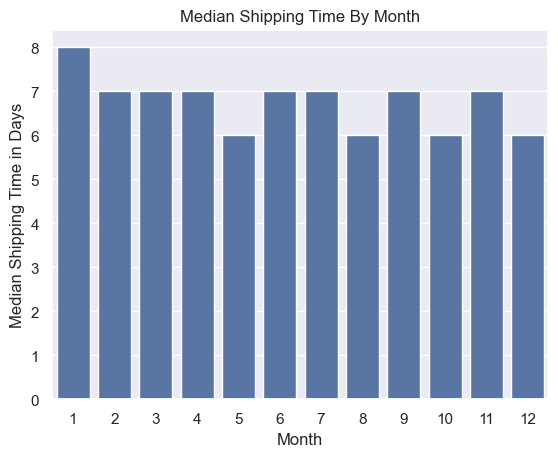

In [11]:
#Seasonality of Shipping Time
#Data Preprocessing
Orders_cleaned['ShipTimeInDays']=Orders_cleaned['ShippingTime']/pd.Timedelta(days=1)
Orders_cleaned['ShippingMonth']=Orders_cleaned['ShippedDate'].dt.month
shiptime_by_month= Orders_cleaned.groupby('ShippingMonth')['ShipTimeInDays'].median()

#Bar graph of median shipping time per month
plt.title('Median Shipping Time By Month')
sns.barplot(shiptime_by_month)
plt.xlabel('Month')
plt.ylabel('Median Shipping Time in Days')

In [12]:
#Shipping Time By Country
import plotly.express as px

#Data Preprocessing
map_df = Orders_cleaned.groupby('ShipCountry')['ShipTimeInDays'].median().reset_index()

#Creating a choropleth map
fig = px.choropleth(
    data_frame=map_df,
    locations="ShipCountry",      
    locationmode="country names",   
    color="ShipTimeInDays",           
    title="Median Shipping Time by Country",
    color_continuous_scale="Blues", 
    projection="natural earth")

#adding the number of shipping days above each country
fig.add_scattergeo(
    locations=map_df["ShipCountry"],
    locationmode="country names",
    text=map_df["ShipTimeInDays"].round(1), 
    mode="text",                           
    hoverinfo="skip"                      
)
fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0}) #reducing margins


fig.show()

C:\Users\ys170\AppData\Local\Temp\ipykernel_11824\2343202211.py:8: DeprecationWarning: The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.
  fig = px.choropleth(


In [13]:
#OTIF

#Data Preprocessing 

Orders_cleaned['OnTime']=Orders_cleaned.apply(lambda row: True if row['RequiredDate']>row['ShippedDate'] else False ,axis=1)
OnTime_df = Orders_cleaned.groupby('OnTime')['OrderID'].count()
print(OnTime_df)
OTIF = OnTime_df[True]/OnTime_df.sum()
print(f'Northwind OTIF rate is: {OTIF.round(2)*100}%')


OnTime
False     40
True     769
Name: OrderID, dtype: int64
Northwind OTIF rate is: 95.0%


C:\Users\ys170\AppData\Local\Temp\ipykernel_11824\118381912.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



   CustomerID  TotalIncome                    CompanyName  Country
60      QUICK    117483.39                     QUICK-Stop  Germany
68      SAVEA    115673.39             Save-a-lot Markets      USA
19      ERNSH    113236.68                   Ernst Handel  Austria
35      HUNGO     57317.39   Hungry Owl All-Night Grocers  Ireland
62      RATTC     52245.90     Rattlesnake Canyon Grocery      USA
..        ...          ...                            ...      ...
27      GALED       836.70         Galerםa del gastrףnomo    Spain
51      NORTS       649.00                    North/South       UK
40      LAUGB       522.50  Laughing Bacchus Wine Cellars   Canada
41      LAZYK       357.00           Lazy K Kountry Store      USA
12      CENTC       100.80     Centro comercial Moctezuma   Mexico

[89 rows x 4 columns]
Northwind top 3 customers are 
    CustomerID  TotalIncome         CompanyName  Country
60      QUICK    117483.39          QUICK-Stop  Germany
68      SAVEA    115673.39  S

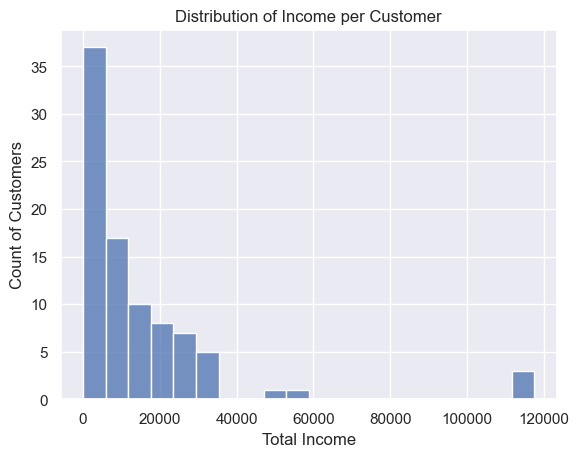

Northwind's customers outliers by revenue: 
   CustomerID  TotalIncome                   CompanyName  Country
60      QUICK    117483.39                    QUICK-Stop  Germany
68      SAVEA    115673.39            Save-a-lot Markets      USA
19      ERNSH    113236.68                  Ernst Handel  Austria
35      HUNGO     57317.39  Hungry Owl All-Night Grocers  Ireland
62      RATTC     52245.90    Rattlesnake Canyon Grocery      USA

Northwind CCR rate is 25.57%

Northwind's Profitable customers
:   CustomerID  TotalIncome                   CompanyName  Country
60      QUICK    117483.39                    QUICK-Stop  Germany
68      SAVEA    115673.39            Save-a-lot Markets      USA
19      ERNSH    113236.68                  Ernst Handel  Austria
35      HUNGO     57317.39  Hungry Owl All-Night Grocers  Ireland
62      RATTC     52245.90    Rattlesnake Canyon Grocery      USA

        Country  CustomerID  TotalIncome           Cluster
0     Argentina           3      8119.1

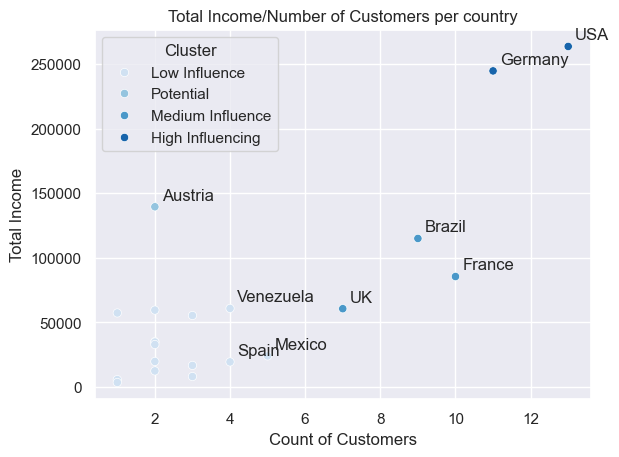

In [14]:
#Calculating CCR
#Checking for nulls
# print(OrderDetails.info())
# print(Orders.info())
# print(Customers.info())

#Cleaning and pre processing
OrderDetails['TotalIncome']=OrderDetails['UnitPrice']*OrderDetails['Quantity']
revenue_per_order =OrderDetails.groupby('OrderID')['TotalIncome'].sum().reset_index()

revenue_per_customer = pd.merge(revenue_per_order,Orders[['OrderID','CustomerID']],on='OrderID')
revenue_per_customer = revenue_per_customer.groupby('CustomerID')['TotalIncome'].sum() 
revenue_per_customer = pd.merge(revenue_per_customer,Customers[['CustomerID','CompanyName','Country']],on='CustomerID')
revenue_per_customer= revenue_per_customer.sort_values(by='TotalIncome',ascending=False)
print(revenue_per_customer)
top3_customers = revenue_per_customer.nlargest(3,'TotalIncome')
print(f"Northwind top 3 customers are \n {top3_customers}\n")

#displaying distribution of incomes per customers
sns.set_theme()
sns.histplot(revenue_per_customer['TotalIncome'],bins=20)
plt.title('Distribution of Income per Customer')
plt.ylabel('Count of Customers')
plt.xlabel("Total Income")
plt.show()

#Studying Outliers
revenue_outliers = get_outliers(revenue_per_customer,'TotalIncome')
print(f"Northwind's customers outliers by revenue: \n{revenue_outliers['df_high_outliers']}\n")

#Calculation of CCR 
top3_revenue = top3_customers['TotalIncome'].sum()
total_revenue = revenue_per_customer['TotalIncome'].sum()
CCR = top3_revenue/total_revenue*100
print(f"Northwind CCR rate is {CCR.round(2)}%\n")

#Studying Companies Customers 
profitable_customers = revenue_per_customer[revenue_per_customer['TotalIncome']>revenue_outliers['mean']]
print(f"Northwind's Profitable customers\n:{profitable_customers.head()}\n")
#Company's above average customers by revenue are the same customers labeled as outliers. 

#Preparing data for scatterolot
customers_per_country = revenue_per_customer.groupby('Country').agg({'CustomerID':'count','TotalIncome':'sum'}).reset_index()
texts = customers_per_country['Country'].tolist()
def get_clusters(row):
    if row['TotalIncome']>150000:
        return 'High Influencing'
    elif row['CustomerID']>6:
        return 'Medium Influence'
    elif row['TotalIncome']>100000:
        return 'Potential'
    else: return 'Low Influence'
customers_per_country['Cluster']=customers_per_country.apply(get_clusters,axis =1 )    
print(customers_per_country)
    
#Creating a scatterplot
sns.scatterplot(data=customers_per_country,x='CustomerID',y='TotalIncome',hue='Cluster',palette='Blues')
plt.xlabel("Count of Customers")
plt.ylabel("Total Income")
plt.title("Total Income/Number of Customers per country")
#adding labels to "intresting" points
for i, row in customers_per_country.iterrows():
    if row['TotalIncome']>=100000 or row['CustomerID']>=4:
        plt.annotate(
            text=row['Country'],                      
            xy=(row['CustomerID'], row['TotalIncome']), 
            xytext=(5, 5),                         
            textcoords='offset points'               
    )



In [15]:
#Saving progress to excel 

with pd.ExcelWriter('NorthwindCleaned.xlsx') as writer:
    Products.to_excel(writer, sheet_name='Products')
    Suppliers.to_excel(writer, sheet_name='Suppliers')
    OrderDetails.to_excel(writer, sheet_name='OrderDetails')
    Categories.to_excel(writer, sheet_name='Categories')
    Territories.to_excel(writer, sheet_name='Territories')
    Region.to_excel(writer, sheet_name='Region')
    EmployeeTerritories.to_excel(writer, sheet_name='EmployeeTerritories')
    Employees.to_excel(writer, sheet_name='Employees')
    Orders_cleaned.to_excel(writer, sheet_name='OrdersCleaned')
    Shippers.to_excel(writer, sheet_name='Shippers')
    Customers.to_excel(writer, sheet_name='Customers')







